## Fitting a SARIMA Model for VIX

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import kpss
import pmdarima as pm
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

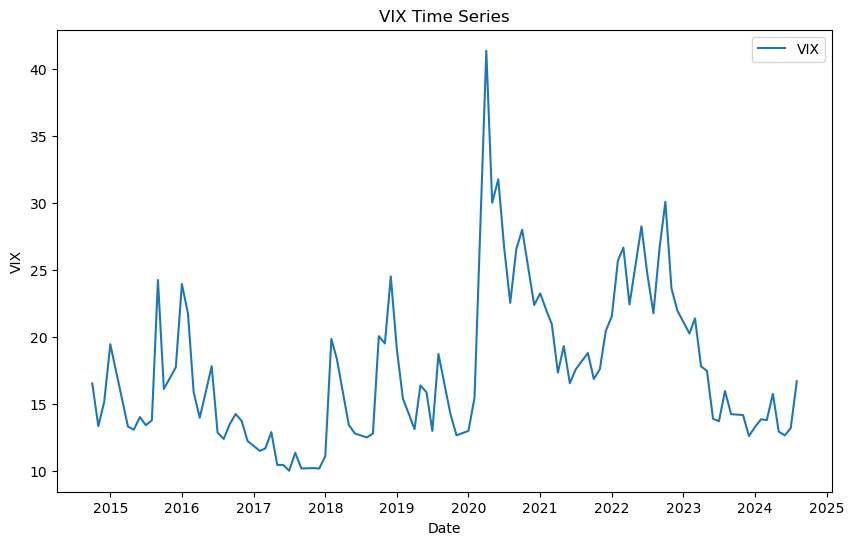

In [50]:
# Load the VIX data
# Assuming you have a CSV file with VIX data
all_data = pd.read_csv('vix_data.csv', index_col='Date', parse_dates=True)
vix_data = all_data[['VIX']]
vix_data = vix_data.dropna()
vix_training = vix_data[:'2023']

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(vix_data, label='VIX')
plt.title('VIX Time Series')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()

ADF Statistic: -4.048220749546327
p-value: 0.0011780302124283187
KPSS Statistic: 0.3971240943739141
p-value: 0.07839478690779564
PP Statistic: -4.3056644833216255
p-value: 0.00043428550733019475


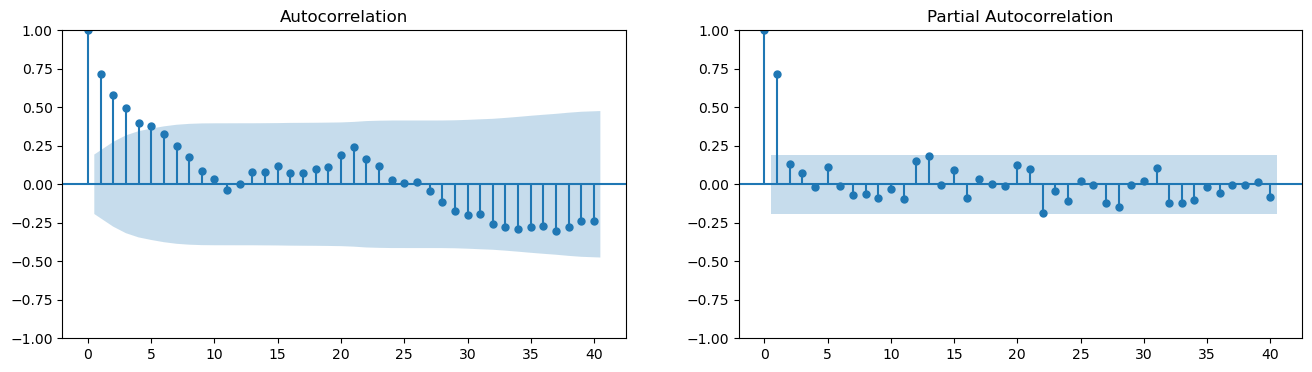

In [13]:
# Run tests to check if the data is stationary
## ADF Test
result = adfuller(vix_data['VIX'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

## KPSS Test
result = kpss(vix_data['VIX'])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

## PP Test
result = PhillipsPerron(vix_data['VIX'])
print('PP Statistic:', result.stat)
print('p-value:', result.pvalue)

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig = sm.graphics.tsa.plot_acf(vix_data['VIX'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(vix_data['VIX'], lags=40, ax=axes[1])
plt.show()

ADF Statistic: -6.797692919312295
p-value: 2.2786906232988513e-09
KPSS Statistic: 0.05379600971047048
p-value: 0.1
PP Statistic: -16.474563118100093
p-value: 2.2666744913225013e-29


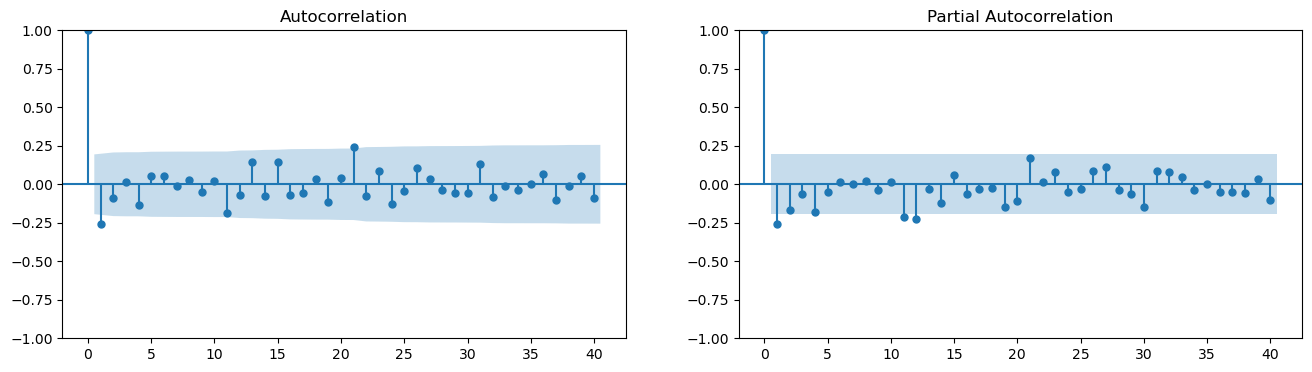

In [14]:
# Difference the data and run the tests again
vix_data['VIX_diff'] = vix_data['VIX'].diff()
vix_data = vix_data.dropna()

## ADF Test
result = adfuller(vix_data['VIX_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

## KPSS Test
result = kpss(vix_data['VIX_diff'])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

## PP Test
result = PhillipsPerron(vix_data['VIX_diff'])
print('PP Statistic:', result.stat)
print('p-value:', result.pvalue)

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig = sm.graphics.tsa.plot_acf(vix_data['VIX_diff'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(vix_data['VIX_diff'], lags=40, ax=axes[1])
plt.show()

In [52]:
# Fit the SARIMA model
model = SARIMAX(vix_data['VIX'], order=(1, 0, 1), seasonal_order=(0, 1, 1, 12))
results = model.fit()

# Forecast next six months
forecast = results.get_forecast(steps=6)
forecast_index = pd.date_range(start=vix_data.index[-1], periods=7, freq='M')[1:]
forecast_values = forecast.predicted_mean.values
forecasted_data = pd.DataFrame(forecast_values, columns=['Forecasted VIX'])
forecasted_data.index = forecast_index

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68187D+00    |proj g|=  6.81129D-02

At iterate    5    f=  2.60386D+00    |proj g|=  9.06424D-03

At iterate   10    f=  2.59953D+00    |proj g|=  6.97608D-04

At iterate   15    f=  2.59923D+00    |proj g|=  5.03960D-04

At iterate   20    f=  2.59918D+00    |proj g|=  7.20002D-05

At iterate   25    f=  2.59917D+00    |proj g|=  2.09323D-04


 This problem is unconstrained.



At iterate   30    f=  2.59917D+00    |proj g|=  6.13125D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   7.530D-06   2.599D+00
  F =   2.5991682855775187     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [49]:
forecast_index = pd.date_range(start=vix_data.index[-1], periods=7, freq='Month')[1:]
forecast_index

ValueError: Invalid frequency: Month, failed to parse with error message: ValueError("Invalid frequency: MONTH, failed to parse with error message: KeyError('MONTH')")

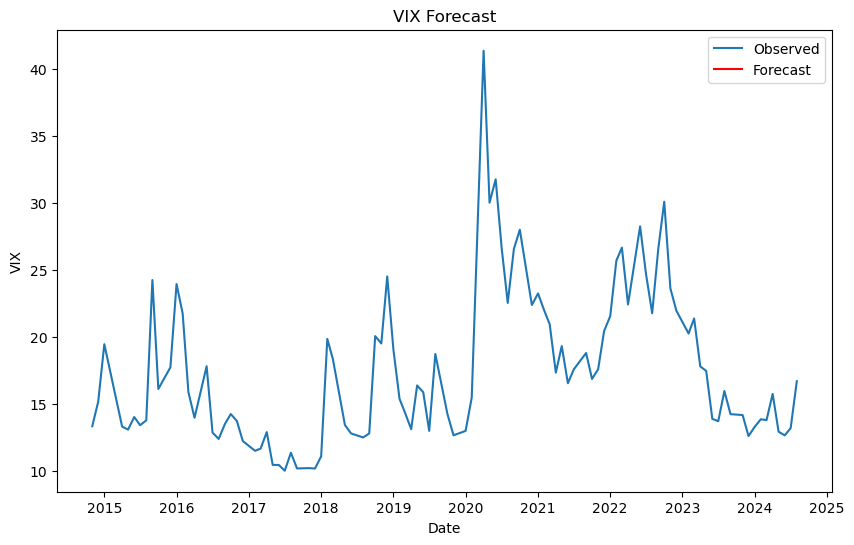

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(vix_data['VIX'], label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('VIX Forecast')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()